In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from van_code.nn import NeuralVANMultilevel_block_wise
from van_code.ising import ising_energy,analytical_solution,local_ising_energy
from van_code.montecarlo import *
from van_code.utils import *
from van_code.obs import Obs


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    default_dtype_torch=torch.float32
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = torch.device("cpu")
print(f'You are using device={device}.')

You are using device=mps.


-------------
-------------
# Model and parameters
Our multilevel architecture uses different blocks of Autoregressive neural networks which are based on the VAN architecture by [Wu et al. (2019)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.080602).

In [3]:
# This cell defines important parameters for the simulation

Lc=2 # defines the coarser lattice
beta=0.44 # defines the beta value (inverse of the temperature)

# VAN parameters
net_depth = 3
net_width= 16
half_kernel_size =6

# CNN VAN parameters
# The i-th element of the list correspond to the parameters associated to the i-th block in the multilevel

hidden_size=[[16]] * 10 # Hidden size of each CondVAN
kernel_size=[5] *10  # Kernel of CondVAN

# @ELIA what is the difference between VAN above, the CondVAN, and CNN VAN? We should make it clear!

nlevels = 2 # defines the numbe rof levels in the multilevel. Every level doubles the lattice. Example: if the coarser is 2x2 after 3 levels we have 16x16
hb_last = True # whether to use heatbath to sample unbiased configuration from the last ARNN

pretrained = True  # wheter to initilize j block with j-1 block's parameters @ELIA Can you explain this better?


In [4]:
van_hyp={
    'net_depth':net_depth,
    'net_width': net_width,
    'half_kernel_size':half_kernel_size,
    'bias':False,'z2':False,
    'res_block':True,
    'x_hat_clip':False,
    'final_conv':True,
    'epsilon':1.e-8,
    'device':device
}

block_net_hyp={
    'hidden_size':hidden_size,
    'kernel_size':kernel_size,
    'epsilon':1e-7,
    'level':0,
    'device':device
}

In [5]:
# Building the model

model = NeuralVANMultilevel_block_wise(
    Lc,
    van_hyp,
    block_net_hyp,
    nlevels,
    hb_last,
    ising_energy,
    local_ising_energy,
    beta,
    device
)
Lf = model.Lf
#print(model)

print(f'\n\n=======================================================================================================================================================\n')
print(f'You will start from coarser lattices of shape {Lc}x{Lc} and sample finer lattices of resolution {model.Lf}x{model.Lf} using {nlevels} multilevel steps.')
print(f'\n=======================================================================================================================================================\n')




You will start from coarser lattices of shape 2x2 and sample finer lattices of resolution 16x16 using 3 multilevel steps.




In [6]:
# Define default parameters for optimizer and scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.92, patience=1000, min_lr=1e-07)

# Define additional training parameters. Arbitrary values can be chosen
# the values chosen below are optimized for the purpose of this demo.

bs = [16] * (nlevels+1)
nepochs = 2 * [500] * nlevels + [500]
print_freq = 10
lr = 2 * [0.001] + [0.001] * (nlevels-1)

In [7]:
# Choose main path to store model and logs
main_path=''+'../data/'

# Creates model identifier with corresponding params
# '/Lf'+'_beta'+'_nblocks'+'_PCNNdepth'+'_width'+'_half_ker'+'_CCNNhs'+'_ks'

model_id = f'{str(model.Lf)}_{str(beta)}_{str(nlevels)}_{str(net_depth)}_{str(net_width)}_{str(half_kernel_size)}_{str(hidden_size[0][0])}_{str(kernel_size[0])}'

lc_path = main_path + 'training/' + model_id
h_path = lc_path + '_history.log' # Path to Training history

## Dict of paths to store different results

res_paths = {
    'weights': main_path+ 'model/'+ model_id +'.chckpnt', # models' weights
    'sim' : main_path + 'results/' + model_id + '_measures.log',  # Simulations logging
    'sim_md' : main_path + 'results/' + model_id + '_measures_modedrop.log',  # Simulations mode dropping
    'cluster' : main_path + 'results/' + model_id + '_measuresCluster.log',  # Simulations
    'dict_hist' : lc_path + '_historyDict.pkl',  # dictionary learning curve
    'mh' : main_path+'results/'+ model_id +'_measuresIMH.log' # neural MCMC sampling results
}


-------------
-------------
# Training

In [8]:
# Load model if checkpoint exists, otherwise train a new model.

if os.path.exists(res_paths['weights']):
    print(f'\n============================================================================================================================\n')
    print(f"Loading model {res_paths['weights']}.")
    print(f'\n============================================================================================================================\n')
    load(model, optimizer, res_paths['weights'])
    with open(res_paths['dict_hist'], 'rb') as handle:
        history= pickle.load(handle)
    print(f'\n============================================================================================================================\n')
    print(f"Loading successful!")
    print(f'\n============================================================================================================================\n')

else:
    print(f'\n============================================================================================================================\n')
    print(f"Nothing to load. Training of new model... ")
    print(f'\n============================================================================================================================\n')

    history=model.train(nepochs, bs, lr, print_freq, h_path, pretrained, on_file=True)
    save(model, optimizer, res_paths['weights'])
    write(history, lc_path)

    print(f'\n============================================================================================================================\n')
    print(f"Training successful!")
    print(f'\n============================================================================================================================\n')




Nothing to load. Training of new model... 


Training VAN layers...


/Users/kimnicoli/Projects/multilevelRG/venv/lib/python3.9/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


10 -0.0229491 -2.5482035 2.376858 0.12304192 -3.7982407 -2.7682035
20 -0.015963137 -2.7724369 1.6171459 0.12522653 -3.850008 -2.7724369
30 -0.01877281 -2.9840608 0.73225653 0.13679679 -3.8168726 -2.7640607
40 -0.049151957 -2.9683857 0.6627169 0.15294091 -3.7019234 -2.7483857
50 -0.38977233 -3.3656783 2.7595196 0.32160327 -4.5578513 -2.7056782
60 -0.62615234 -3.351481 2.0331695 0.37008435 -4.2360463 -2.691481
70 -0.6921334 -4.169017 0.99128306 0.6999538 -4.5342607 -2.1890168
80 -0.4480962 -4.263093 0.4238952 0.87139076 -4.4057484 -1.8430932
90 0.083502404 -4.44978 0.008630501 0.9890719 -4.4542694 -1.1497802
100 -0.107916586 -4.3030653 0.025757305 0.9861484 -4.3131485 -1.0030649
110 -0.053690936 -4.2897816 0.0050762957 0.9962781 -4.291977 -0.9897815
120 -0.07405944 -4.265761 0.0051931995 0.9959133 -4.26806 -1.1857607
130 1.315531e-05 -4.2818866 1.40810325e-05 0.99998665 -4.281893 -0.7618865
140 4.8792936e-06 -4.277116 5.180469e-06 0.99999523 -4.277118 -0.7571157
150 -0.041862957 -4.28218

/Users/kimnicoli/Projects/multilevelRG/venv/lib/python3.9/site-packages/torch/_compile.py:31: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)
/Users/kimnicoli/Projects/multilevelRG/venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


10 -2.9730525 -12.882533 8.800662 0.084409565 -17.05317 -9.362533
20 -4.9976163 -13.940269 3.865408 0.30239648 -15.40251 -8.440269
30 -1.2499275 -15.377146 0.37227473 0.85980254 -15.509138 -3.717146
40 -0.35657665 -15.361813 0.03601429 0.9750871 -15.377081 -3.5918128
50 -0.77516115 -15.276748 0.10442063 0.9442976 -15.317583 -4.276749
60 0.7450986 -15.454123 0.1170413 0.74381614 -15.535208 -2.5841222
70 0.20547679 -15.482303 0.08816128 0.8244671 -15.539112 -3.2723029
80 -0.078419484 -15.463309 0.14387128 0.8614605 -15.531452 -4.0233088
90 0.35053766 -15.475313 0.06707022 0.92319036 -15.509607 -4.475314
100 -0.48531404 -15.474856 0.14870094 0.86090857 -15.546154 -4.8048553
110 0.21144693 -15.521956 0.06412651 0.95188534 -15.549843 -4.5219564
120 -1.2116967 -15.40955 0.19142452 0.95583695 -15.466385 -2.8695498
130 -0.08923599 -15.454542 0.1102099 0.8937464 -15.5073185 -3.904543
140 -0.48551553 -15.376119 0.04487321 0.9713375 -15.394718 -3.606119
150 0.15584525 -15.503258 0.02024541 0.9732

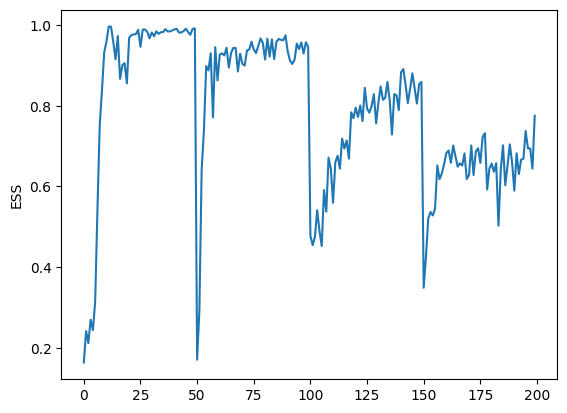

In [9]:
bins = 10 # binning to plot training history.

if history:
    plt.plot(np.asarray(history['ESS']).reshape(int((nepochs[0]*nlevels+nepochs[-1])/bins),bins).mean(-1))
    plt.ylabel('ESS')

-------------
-------------
# Analysis: Reverse Metrics
This sections includes metrics which require samples from the model, e.g., $s\sim q_\theta$ where $q_\theta$ is the autoregressive neural network.
The resulting script `res_paths['sim']` will store:

`Loss, FreeEn, ESS_rev, InternalEn, Absmag`

In [10]:
model.eval()
w,E,m,t = model.sample_n_OBS(100,1000)

In [11]:
gamma_analysis(w, res_paths['sim']) # Stores data: Loss, FreeEn, ESS_rev
_=gamma_analysis_OBS(E, w, res_paths['sim']) # Stores data: Internal Energy
_=gamma_analysis_OBS(np.abs(m), w, res_paths['sim']) # Stores data: Absolute magnetization

-------------
-------------
# Analysis: Forward metrics
> Note to user:
> - This only works for small lattices. As this is just a demo, configurations for larger lattices (or different $\beta$) are not provided and users have to generate reference configurations by themselves. Once configurations are available the pipeline below can be used.
> - Ensure to unzip the configurations before running the code below.


This sections includes metrics which require samples from the true distribution, e.g., $s\sim p$ where $p$ is the target Boltzmann distribution.
Such samples can be obtained with standard methods such as the Cluster method. For the sake of this demo, configs sampled with cluster method are stored in `data/config/Ising_data_nx16_beta0.4400000000_data1000000.dat`.

The script `res_paths['sim_md']` will store:

`Loss_rev, FreeEn_rev, ESS_rev, Loss_fwd, FreeEn_fwd, ESS_fwd, mode_dropping_est,  InternalEn, Absmag`

The script `res_paths['cluster']` will store analysis performed on samples from Cluster method, i.e., $s\sim p$:

`Loss, FreeEn, ESS_rev, InternalEn, Absmag`


In [12]:
ndat = 1000000
path_ising = main_path + f'config/Ising_data_nx{model.Lf}_beta0.4400000000_data{ndat}.dat'

In [ ]:
# Loads data for 16x16
# N.B. This might take some time.
data = np.genfromtxt(path_ising).reshape(-1, Lf, Lf)

In [ ]:
cluster_analysis(data, ising_energy, beta, res_paths['cluster']) # U, tau |m|, tau |m|

In [ ]:
wf = model.sample_from_MCMC(data, 1000)

In [ ]:
gamma_analysis_modedrop(w, wf, res_paths['sim_md']) # Stores data: Loss, betaF, ESS, Floss, FbetaF, FESS, modedrop, U, absmag

-------------
-------------
# Independent Metropolis-Hastings

The cells below run Neural MCMC using a Metropolis Hastings accept-reject steps to unbias the samples drawn from the model as proposed in [Nicoli et al. Phys. Rev. E (2020)](https://link.aps.org/accepted/10.1103/PhysRevE.101.023304). A cluster analysis is performed on the accepted samples and results are saved in `res_paths['mh']`.

In [ ]:
model.eval()

In [ ]:
ensemble=make_mcmc_ensemble(model,100, 1000,model.device)

In [ ]:
np.asarray(ensemble['accepted']).mean()

In [ ]:
cluster_analysis(np.asarray(ensemble['x']).reshape((-1, Lf, Lf) ), model.energy, model.beta, res_paths['mh']) #U, tau |m|, tau |m|